## Assignment : 14

In [0]:
from keras.utils import np_utils 
from keras.datasets import mnist 
import seaborn as sns
from keras.initializers import RandomNormal
from keras.initializers import he_normal
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from collections import Counter 
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import pickle
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import Flatten
from keras.layers import concatenate
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.regularizers import l2
from keras.models import Model
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from keras.models import load_model
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import Image
from tqdm import tqdm_notebook
from keras import optimizers
from keras.layers import LeakyReLU
from collections import Counter
from scipy.sparse import hstack

In [0]:
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [96]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [97]:
root_path = '/content/gdrive/My Drive/LSTM Assignment/'
!ls '/content/gdrive/My Drive/LSTM Assignment'
working_dir = '/content/gdrive/My Drive/model-weights-lstm/'
!ls '/content/gdrive/My Drive/model-weights-lstm/'

 1_Reference_EDA.ipynb		  'LSTM - Assignment.ipynb'   train_data.csv
 2_Reference_Preprocessing.ipynb   preprocessed_data.csv
 glove_vectors			   resources.csv
best_model_1.h5   test-essay-imp.pkl
best_model.h5	  train-essay-imp.pkl
cv-essay-imp.pkl  weights-improvement-01-0.61.hdf5
hello		  weights-improvement-01-0.64.hdf5
model1.png	  weights-improvement-02-0.65.hdf5
model2.png	  weights-improvement-02-0.67.hdf5
tb_1.png


<pre>
1. Download the preprocessed DonorsChoose data from here <a href='https://drive.google.com/file/d/1GU3LIJJ3zS1xLXXe-sdItSJHtI5txjVO/view?usp=sharing'>Dataset</a>
2. Split the data into train, cv, and test
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics'>'auc'</a> as a metric. check <a href='https://datascience.stackexchange.com/a/20192'>this</a> for using auc as a metric. you need to print the AUC value for each epoch. Note: you should NOT use the tf.metric.auc
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum, resources: <a href='http://cs231n.github.io/neural-networks-3/'>cs231n class notes</a>, <a href='https://www.youtube.com/watch?v=hd_KFJ5ktUc'>cs231n class video</a>. 
7. You should Save the best model weights.
8. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in .ipynb notebook and PDF. 
9. Use Categorical Cross Entropy as Loss to minimize.
10. try to get AUC more than 0.8 for atleast one model
</pre>

### Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

In [98]:
df = pd.read_csv(root_path+'preprocessed_data.csv')
print(df.shape)

(109248, 9)


In [99]:
df.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


# Splitting data into Train and Test


In [0]:
Y = df['project_is_approved'].values
df.drop(['project_is_approved'],axis=1,inplace=True)

In [101]:
X_train, X_test, Y_train, Y_test = train_test_split(df,Y,stratify=Y,test_size=0.20)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train,Y_train,stratify=Y_train,test_size=0.20)

print("Size of X_train: ",X_train.shape)
print("Size of Y_train: ",Y_train.shape)

print("Size of X_cv: ",X_cv.shape)
print("Size of Y_cv: ",Y_cv.shape)

print("Size of X_test: ",X_test.shape)
print("Size of Y_test: ",Y_test.shape)

Size of X_train:  (69918, 8)
Size of Y_train:  (69918,)
Size of X_cv:  (17480, 8)
Size of Y_cv:  (17480,)
Size of X_test:  (21850, 8)
Size of Y_test:  (21850,)


# Convert Y label to binary class matrix

In [102]:
Y_train = to_categorical(Y_train,num_classes=2)
Y_cv = to_categorical(Y_cv,num_classes=2)
Y_test = to_categorical(Y_test, num_classes=2)
print("Shape of Y_train: ", Y_train.shape)
print("Shape of Y_cv: ", Y_cv.shape)
print("Shape of Y_test: ",Y_test.shape)

Shape of Y_train:  (69918, 2)
Shape of Y_cv:  (17480, 2)
Shape of Y_test:  (21850, 2)


# Encoding text data as integers
* Keras offers an Embedding layer that can be used for neural networks on text data.

* It requires that the input data be integer encoded, so that each word is represented by a unique integer.


In [103]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train['essay'])
vocab_size = len(t.word_index) + 1
print("Vocabulary Size: ",vocab_size)

Vocabulary Size:  47336


In [104]:
# # integer encode the documents
encoded_train_essay = t.texts_to_sequences(X_train['essay'])
encoded_cv_essay = t.texts_to_sequences(X_cv['essay'])
encoded_test_essay = t.texts_to_sequences(X_test['essay'])
print(encoded_train_essay[0])

[719, 1, 437, 764, 23, 719, 1, 493, 35, 1076, 3764, 71, 1061, 218, 226, 30363, 71, 317, 9555, 59, 176, 421, 3, 30, 2, 34, 1, 1171, 19, 5, 841, 220, 1, 94, 194, 2568, 329, 196, 3429, 1961, 117, 37, 539, 1, 492, 464, 195, 9, 437, 48, 110, 495, 238, 488, 9, 34, 290, 48, 592, 2, 50, 231, 209, 418, 2, 20, 82, 1, 418, 2, 34, 33, 35, 9, 15, 75, 152, 705, 10, 705, 2, 19, 1, 20, 159, 705, 450, 267, 719, 375, 27, 159, 71, 627, 1930, 1, 294, 687, 3, 5, 27, 15, 4, 1, 687, 364, 9, 34, 159, 118, 475, 188, 535, 3, 1198, 11637, 231, 78, 719, 60, 26, 499, 130, 719, 60, 8, 800, 897, 3957, 331, 499, 261, 349, 86, 6, 2, 34, 1, 20, 10, 475, 326, 337, 57, 2, 235, 394, 1, 75, 159, 327, 3, 101, 69, 250, 57, 2, 19, 18, 3310, 8378, 23, 1, 285, 138, 159, 297, 1348, 1165, 1492, 1, 28, 18, 26, 56, 968, 194, 460, 26, 153, 2, 34, 1, 100, 724, 259, 124, 719, 1, 238, 336, 12, 312, 8, 102, 2524, 15198, 170, 8, 18, 15198, 252, 774, 2, 34, 1237, 19, 5, 719, 1, 365, 3, 268, 772, 203, 6, 2, 49, 1180, 1, 418, 7, 232, 252, 1

# Analysing Essay lengths to find the padding size

In [0]:
len_of_essays = []
for essay in encoded_train_essay:
    len_of_essays.append(len(essay))

uniq_len = list(set(len_of_essays))
freq = []
for c in uniq_len:
    freq.append(len_of_essays.count(c))

In [106]:
print("Mean Length of Essays = ", sum(len_of_essays)/len(len_of_essays))

Mean Length of Essays =  151.39409021997196


Plotting distribution of essay length

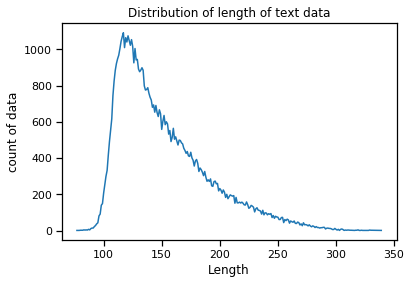

In [107]:
%matplotlib inline
sns.set_context('notebook')
plt.plot(uniq_len,freq)
plt.xlabel('Length')
plt.ylabel('count of data')
plt.title('Distribution of length of text data')
plt.show()

# Conclusion
* As observed from the distribution a essay lenth of  **300** covers most of the data points.

In [108]:
max_length = 300
padded_train_essay = pad_sequences(encoded_train_essay, maxlen=max_length, padding='post')
padded_cv_essay = pad_sequences(encoded_cv_essay, maxlen=max_length, padding='post')
padded_test_essay = pad_sequences(encoded_test_essay, maxlen=max_length, padding='post')
print("After padding train essay",padded_train_essay[0])
print("After padding cv essay",padded_cv_essay[0])
print("After padding test essay",padded_test_essay[0])

After padding train essay [  719     1   437   764    23   719     1   493    35  1076  3764    71
  1061   218   226 30363    71   317  9555    59   176   421     3    30
     2    34     1  1171    19     5   841   220     1    94   194  2568
   329   196  3429  1961   117    37   539     1   492   464   195     9
   437    48   110   495   238   488     9    34   290    48   592     2
    50   231   209   418     2    20    82     1   418     2    34    33
    35     9    15    75   152   705    10   705     2    19     1    20
   159   705   450   267   719   375    27   159    71   627  1930     1
   294   687     3     5    27    15     4     1   687   364     9    34
   159   118   475   188   535     3  1198 11637   231    78   719    60
    26   499   130   719    60     8   800   897  3957   331   499   261
   349    86     6     2    34     1    20    10   475   326   337    57
     2   235   394     1    75   159   327     3   101    69   250    57
     2    19    18  3310 

# Using Glove Embedding for essays

In [0]:
def get_embedding_matrix(tokenizer,vocab_size):
  '''
  Takes input a tokenizer trained on the training set and vocabulary size
  
  Returns glove vector encoding for each word in the vocabulary (300 dim)
  as embedding_matrix.
  '''

  with open(root_path+'glove_vectors', 'rb') as f:
      model = pickle.load(f)
      glove_words =  set(model.keys())

  embedding_matrix = np.zeros((vocab_size, 300))
  cnt=0
  for word, i in tokenizer.word_index.items():
    if word in glove_words:
      embedding_matrix[i] = model[word]
  return embedding_matrix

In [110]:
embedding_matrix_train = get_embedding_matrix(t,vocab_size)
print(embedding_matrix_train.shape)

(47336, 300)


<h2>Make Data Model Ready: encoding numerical, categorical features</h2>


## Encoding Categorical Features

In [0]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
#credits: https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

**Integer Encoding: clean_categories**

In [112]:
category_encoder = LabelEncoderExt()

category_encoder.fit(list(X_train['clean_categories']))
print(category_encoder.classes_) # you can see new class called Unknown
#total number of unique category classes
category_vocab_size = len(category_encoder.classes_)
print("Category size: ", category_vocab_size)

category_encoded_train =  category_encoder.transform(X_train['clean_categories'])
category_encoded_cv =  category_encoder.transform(X_cv['clean_categories'])
category_encoded_test =  category_encoder.transform(X_test['clean_categories'])
category_embd_size = min(50,category_vocab_size//2+1)

print(category_encoded_train)
print(category_encoded_cv)
print(category_encoded_test)
print(category_embd_size)

['Unknown' 'appliedlearning' 'appliedlearning health_sports'
 'appliedlearning history_civics' 'appliedlearning literacy_language'
 'appliedlearning math_science' 'appliedlearning music_arts'
 'appliedlearning specialneeds' 'appliedlearning warmth care_hunger'
 'health_sports' 'health_sports appliedlearning'
 'health_sports history_civics' 'health_sports literacy_language'
 'health_sports math_science' 'health_sports music_arts'
 'health_sports specialneeds' 'health_sports warmth care_hunger'
 'history_civics' 'history_civics appliedlearning'
 'history_civics health_sports' 'history_civics literacy_language'
 'history_civics math_science' 'history_civics music_arts'
 'history_civics specialneeds' 'history_civics warmth care_hunger'
 'literacy_language' 'literacy_language appliedlearning'
 'literacy_language health_sports' 'literacy_language history_civics'
 'literacy_language math_science' 'literacy_language music_arts'
 'literacy_language specialneeds' 'literacy_language warmth care_h

**Integer Encoding: clean_subcategories**

In [113]:
subcategory_encoder = LabelEncoderExt()

subcategory_encoder.fit(list(X_train['clean_subcategories']))
print(subcategory_encoder.classes_) # you can see new class called Unknown
#total number of unique category classes
subcategory_vocab_size = len(subcategory_encoder.classes_)
print("subcategory size: ", subcategory_vocab_size)

subcategory_encoded_train =  subcategory_encoder.transform(X_train['clean_subcategories'])
subcategory_encoded_cv =  subcategory_encoder.transform(X_cv['clean_subcategories'])
subcategory_encoded_test =  subcategory_encoder.transform(X_test['clean_subcategories'])
subcategory_embd_size = min(50,subcategory_vocab_size//2+1)


print(subcategory_encoded_train)
print(subcategory_encoded_test)
print(subcategory_encoded_cv)
print(subcategory_embd_size)

['Unknown' 'appliedsciences' 'appliedsciences charactereducation'
 'appliedsciences civics_government' 'appliedsciences college_careerprep'
 'appliedsciences communityservice' 'appliedsciences earlydevelopment'
 'appliedsciences economics' 'appliedsciences environmentalscience'
 'appliedsciences esl' 'appliedsciences extracurricular'
 'appliedsciences financialliteracy' 'appliedsciences foreignlanguages'
 'appliedsciences gym_fitness' 'appliedsciences health_lifescience'
 'appliedsciences health_wellness' 'appliedsciences history_geography'
 'appliedsciences literacy' 'appliedsciences literature_writing'
 'appliedsciences mathematics' 'appliedsciences music'
 'appliedsciences nutritioneducation' 'appliedsciences other'
 'appliedsciences parentinvolvement' 'appliedsciences performingarts'
 'appliedsciences socialsciences' 'appliedsciences specialneeds'
 'appliedsciences teamsports' 'appliedsciences visualarts'
 'appliedsciences warmth care_hunger' 'charactereducation'
 'charactereducati

**Integer Encoding: school_state**

In [114]:
school_state_encoder = LabelEncoderExt()

school_state_encoder.fit(list(X_train['school_state']))
print(school_state_encoder.classes_) # you can see new class called Unknown
#total number of unique school_state classes
school_state_vocab_size = len(school_state_encoder.classes_)
print("school_state_vocab_size: ", school_state_vocab_size)

school_state_encoded_train =  school_state_encoder.transform(X_train['school_state'])
school_state_encoded_cv =  school_state_encoder.transform(X_cv['school_state'])
school_state_encoded_test =  school_state_encoder.transform(X_test['school_state'])
school_state_embd_size = min(50,school_state_vocab_size//2+1)
print(school_state_encoded_train)
print(school_state_encoded_cv)
print(school_state_encoded_test)
print(school_state_embd_size)

['Unknown' 'ak' 'al' 'ar' 'az' 'ca' 'co' 'ct' 'dc' 'de' 'fl' 'ga' 'hi'
 'ia' 'id' 'il' 'in' 'ks' 'ky' 'la' 'ma' 'md' 'me' 'mi' 'mn' 'mo' 'ms'
 'mt' 'nc' 'nd' 'ne' 'nh' 'nj' 'nm' 'nv' 'ny' 'oh' 'ok' 'or' 'pa' 'ri'
 'sc' 'sd' 'tn' 'tx' 'ut' 'va' 'vt' 'wa' 'wi' 'wv' 'wy']
school_state_vocab_size:  52
[ 2  4  5 ... 29  5 11]
[44 18  7 ... 16 34 11]
[ 5  5  5 ... 10 35 10]
27


**Integer Encoding: teacher_prefix**

In [115]:
teacher_prefix_encoder = LabelEncoderExt()

teacher_prefix_encoder.fit(list(X_train['teacher_prefix']))
print(teacher_prefix_encoder.classes_) # you can see new class called Unknown
#total number of unique techer_prefix classes
teacher_prefix_vocab_size = len(teacher_prefix_encoder.classes_)
print("techer_prefix_vocab_size: ", teacher_prefix_vocab_size)

teacher_prefix_encoded_train =  teacher_prefix_encoder.transform(X_train['teacher_prefix'])
teacher_prefix_encoded_cv =  teacher_prefix_encoder.transform(X_cv['teacher_prefix'])
teacher_prefix_encoded_test =  teacher_prefix_encoder.transform(X_test['teacher_prefix'])

teacher_prefix_embd_size = min(50,teacher_prefix_vocab_size//2+1)

print(teacher_prefix_encoded_train)
print(teacher_prefix_encoded_cv)
print(teacher_prefix_encoded_test)
print(teacher_prefix_embd_size)

['Unknown' 'dr' 'mr' 'mrs' 'ms' 'teacher']
techer_prefix_vocab_size:  6
[3 3 3 ... 3 4 3]
[2 2 2 ... 3 2 3]
[4 4 4 ... 4 3 3]
4


**Integer Encoding: project_grade_category**

In [116]:
project_grade_cat_encoder = LabelEncoderExt()

project_grade_cat_encoder.fit(list(X_train['project_grade_category']))
print(project_grade_cat_encoder.classes_) # you can see new class called Unknown
project_grade_cat_size = len(project_grade_cat_encoder.classes_)
print("project_grade_cat_size: ", project_grade_cat_size)

project_grade_cat_encoded_train =  project_grade_cat_encoder.transform(X_train['project_grade_category'])
project_grade_cat_encoded_cv =  project_grade_cat_encoder.transform(X_cv['project_grade_category'])
project_grade_cat_encoded_test =  project_grade_cat_encoder.transform(X_test['project_grade_category'])
project_grade_cat_embd_size = min(50,project_grade_cat_size//2+1)

print(project_grade_cat_encoded_train)
print(project_grade_cat_encoded_train)
print(project_grade_cat_encoded_test)
print(project_grade_cat_embd_size)

['Unknown' 'grades_3_5' 'grades_6_8' 'grades_9_12' 'grades_prek_2']
project_grade_cat_size:  5
[1 1 1 ... 1 4 4]
[1 1 1 ... 1 4 4]
[4 4 4 ... 4 2 4]
3


##Encoding Numerical features

**Normalizing Price**

In [117]:
price_vectorizer = preprocessing.Normalizer().fit(X_train['price'].values.reshape(1,-1))
X_train_price_normalized = price_vectorizer.transform(X_train['price'].values.reshape(1,-1))
X_cv_price_normalized = price_vectorizer.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_normalized = price_vectorizer.transform(X_test['price'].values.reshape(1, -1))


X_train_price_normalized = X_train_price_normalized.reshape(-1,1)
X_cv_price_normalized = X_cv_price_normalized.reshape(-1,1)
X_test_price_normalized = X_test_price_normalized.reshape(-1,1)

print(X_train_price_normalized.shape)
print(X_cv_price_normalized.shape)
print(X_test_price_normalized.shape)

(69918, 1)
(17480, 1)
(21850, 1)


**Normalize teacher_number_of_previously_posted_projects**

In [0]:
project_vectorizer = preprocessing.Normalizer().fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_train_normal_previous_project = project_vectorizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1, -1))
X_cv_normal_previous_project = project_vectorizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1, -1))
X_test_normal_previous_project = project_vectorizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1, -1))

In [119]:
X_train_normal_previous_project = X_train_normal_previous_project.reshape(-1,1)
X_cv_normal_previous_project = X_cv_normal_previous_project.reshape(-1,1)
X_test_normal_previous_project = X_test_normal_previous_project.reshape(-1,1)
print(X_train_normal_previous_project.shape)
print(X_cv_normal_previous_project.shape)
print(X_test_normal_previous_project.shape)

(69918, 1)
(17480, 1)
(21850, 1)


In [120]:
remaining_train = np.hstack((X_train_price_normalized,X_train_normal_previous_project))
remaining_cv = np.hstack((X_cv_price_normalized,X_cv_normal_previous_project))
remaining_test = np.hstack((X_test_price_normalized,X_test_normal_previous_project))
print(remaining_train.shape,Y_train.shape)
print(remaining_cv.shape,Y_cv.shape)
print(remaining_test.shape, Y_test.shape)

(69918, 2) (69918, 2)
(17480, 2) (17480, 2)
(21850, 2) (21850, 2)


### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

# Creating Model 1

In [0]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

#First Input : Essays
essay_input = Input(shape=(300,), name='essay_input')
embedding = Embedding(input_dim=vocab_size,output_dim=300,weights=[embedding_matrix_train],input_length=300)(essay_input)
lstm_output = LSTM(units=150,dropout=0.5,return_sequences=True)(embedding)
flatten_1 = Flatten()(lstm_output)

#Second Input: school state

state_input = Input(shape=(1,),name='school_state')
state_embedding = Embedding(input_dim=school_state_vocab_size,output_dim=school_state_embd_size,input_length=1)(state_input)
flatten_2 = Flatten()(state_embedding)

#Third Input: project grade category
project_grade_cat_input = Input(shape=(1,),name='project_grade_category')
proj_gr_cat_embd = Embedding(input_dim=project_grade_cat_size,output_dim=project_grade_cat_embd_size,input_length=1)(project_grade_cat_input)
flatten_3 = Flatten()(proj_gr_cat_embd)

#Fourth Input: Project Category
project_cat_input = Input(shape=(1,), name='project_category')
proj_cat_embd = Embedding(input_dim=project_grade_cat_size,output_dim=project_grade_cat_embd_size,input_length=1)(project_cat_input)
flatten_4 = Flatten()(proj_cat_embd)

#Fifth Input: Teacher Prefix
teacher_pre_input = Input(shape=(1,),name='teacher_prefix')
teacher_pr_embd = Embedding(input_dim=teacher_prefix_vocab_size,output_dim=teacher_prefix_embd_size,input_length=1)(teacher_pre_input)
flatten_5 = Flatten()(teacher_pr_embd)

#Sixth Input: Project Subucategories
subcat_input = Input(shape=(1,),name='project_subcategory')
subcat_embd = Embedding(input_dim=subcategory_vocab_size,output_dim=subcategory_vocab_size,input_length=1)(subcat_input)
flatten_6 = Flatten()(subcat_embd)

#Remaining Input: Price, Number of previously posted project
remaining_input = Input(shape=(2,),name='remaining_input')
dense_1 = Dense(5, activation='relu',kernel_initializer="he_normal",kernel_regularizer=l2(0.001))(remaining_input)

#concatenating all inputs together
cacatenated_inputs = concatenate([flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,flatten_6,dense_1])

x = Dense(256, activation='relu',kernel_initializer="he_normal",kernel_regularizer=l2(0.001))(cacatenated_inputs)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu',kernel_initializer="he_normal",kernel_regularizer=l2(0.001))(x)
x = Dropout(0.6)(x)
x = BatchNormalization()(x)

x = Dense(64, activation='relu',kernel_initializer="he_normal",kernel_regularizer=l2(0.001))(x)
final_output = Dense(2, activation='softmax')(x)

model_1 = Model(inputs=[essay_input, state_input, project_grade_cat_input, project_cat_input, teacher_pre_input, subcat_input, remaining_input], outputs=[final_output])
print(model_1.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
essay_input (InputLayer)        (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 300, 300)     14203500    essay_input[0][0]                
__________________________________________________________________________________________________
school_state (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
project_grade_category (InputLa (None, 1)            0                                            
____________________________________________________________________________________________

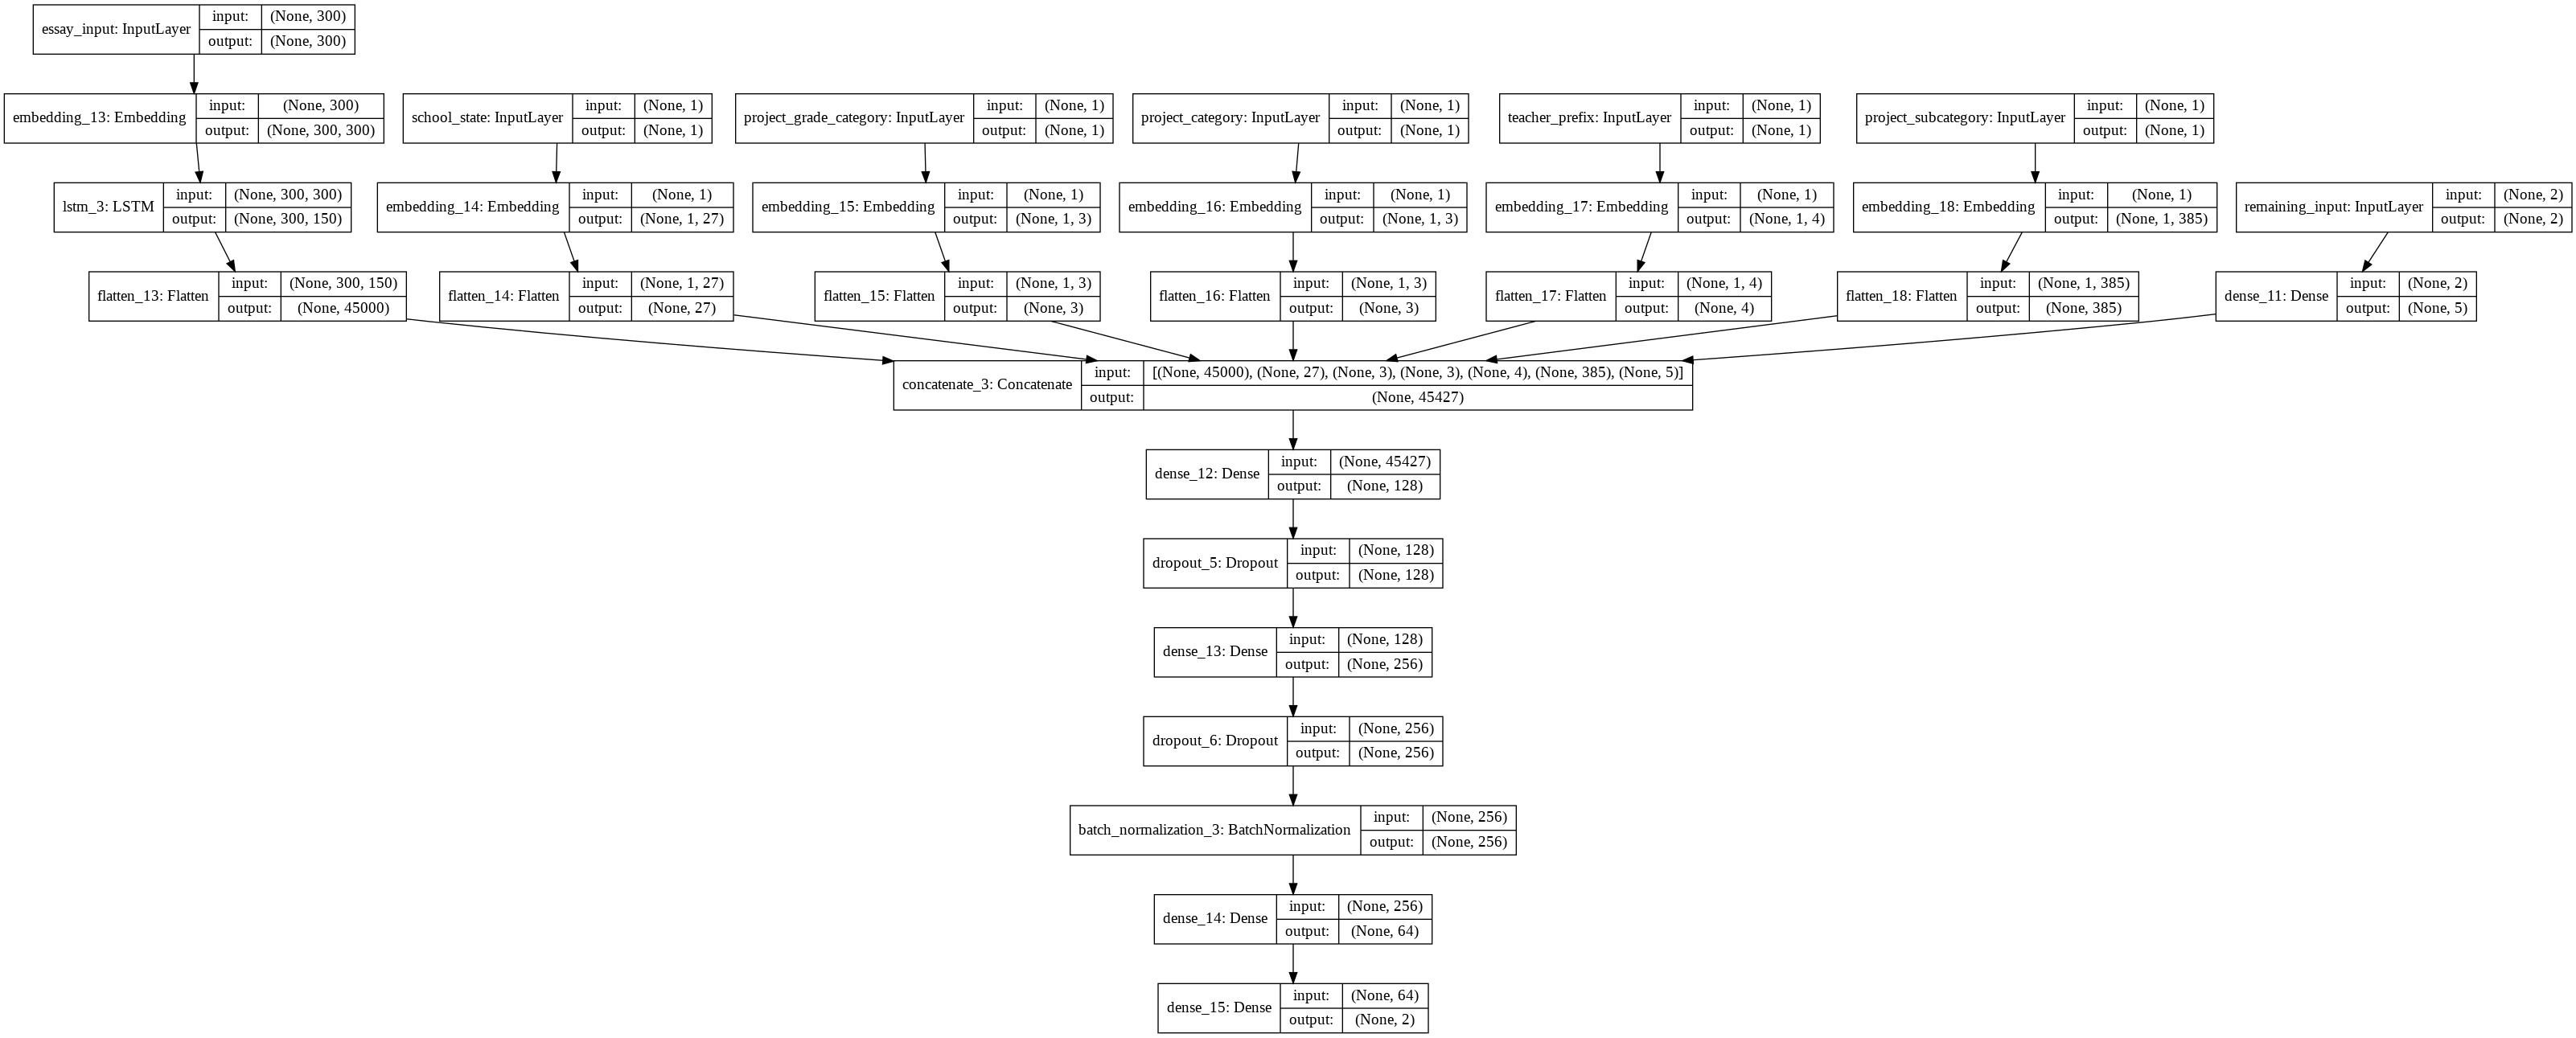

In [0]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model_1, to_file=working_dir+'model1.png', show_shapes=True, show_layer_names=True)

In [0]:
# checkpoint
file_path=working_dir+"weights-improvement-{epoch:02d}-{val_auroc:.2f}.hdf5"
checkpoint_1 = ModelCheckpoint(filepath=file_path,
                             monitor="val_auroc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

earlystop_1 = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

reduce_lr_1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.002,verbose = 1)

tbc=TensorBoardColab()

callbacks_list = [checkpoint_1,earlystop_1,earlystop_1,TensorBoardColabCallback(tbc)]

Wait for 8 seconds...
TensorBoard link:
https://4f618caf.ngrok.io


In [0]:
def auc1(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)

def auroc(y_true, y_pred):
    return tf.py_func(auc1, (y_true, y_pred), tf.double)

In [0]:
train_1 = [padded_train_essay,
           school_state_encoded_train,
           project_grade_cat_encoded_train,
           category_encoded_train,
           teacher_prefix_encoded_train,
           subcategory_encoded_train,
           remaining_train]


cv1 = [padded_cv_essay,
           school_state_encoded_cv,
           project_grade_cat_encoded_cv,
           category_encoded_cv,
           teacher_prefix_encoded_cv,
           subcategory_encoded_cv,
           remaining_cv]

test_1 = [padded_test_essay,
           school_state_encoded_test,
           project_grade_cat_encoded_test,
           category_encoded_test,
           teacher_prefix_encoded_test,
           subcategory_encoded_test,
           remaining_test]

In [0]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auroc])



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [0]:
history_1 = model_1.fit(train_1, Y_train, validation_data=(cv1,Y_cv),batch_size=512, epochs=20, verbose=1,callbacks=callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 69918 samples, validate on 17480 samples


Epoch 1/20
69918/69918 [==============================] - 73s 1ms/step - loss: 1.1789 - auroc: 0.5142 - val_loss: 0.9379 - val_auroc: 0.4245

Epoch 00001: val_auroc improved from -inf to 0.42447, saving model to /content/gdrive/My Drive/model-weights-lstm/weights-improvement-01-0.42.hdf5

Epoch 2/20
69918/69918 [==============================] - 72s 1ms/step - loss: 0.7811 - auroc: 0.5191 - val_loss: 0.7143 - val_auroc: 0.6072

Epoch 00002: val_auroc improved from 0.42447 to 0.60718, saving model to /content/gdrive/My Drive/model-weights-lstm/weights-improvement-02-0.61.hdf5
Epoch 3/20
69918/69918 [==============================] - 72s 1ms/step - loss: 0.6417 - auroc: 0.5088 - val_loss: 0.5913 - val_auroc: 0.5163

Epoch 00003: val_auroc did not improve from 0.60718
Epoch 4/20
69918/69918 [==============================] - 71s 1ms/step - los

In [0]:
#https://stackoverflow.com/posts/54978213/revisions
custom_objects = {"auroc":auroc}
from keras.models import load_model
best_model_1 = load_model('/content/gdrive/My Drive/model-weights-lstm/weights-improvement-08-0.75.hdf5',custom_objects=custom_objects)

In [0]:
result = best_model_1.evaluate(x=test_1, y=Y_test, batch_size=512)

21850/21850 [==============================] - 8s 365us/step


In [0]:
print("{} of test data {}". format(best_model_1.metrics_names[0],result[0]))
print("{} of test data {}". format(best_model_1.metrics_names[1],result[1]))

loss of test data 0.45637781578288744
auroc of test data 0.7424118391000872


In [0]:
best_model_1.save(working_dir+"best_model_1.h5")

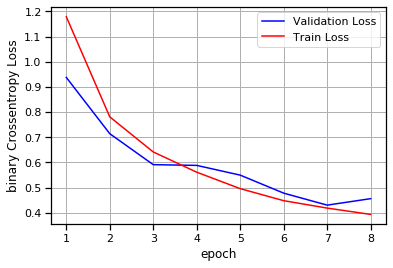

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,8+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history_1.history['val_loss']
ty = history_1.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
def plt_dynamic_auc(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation auc")
    ax.plot(x, ty, 'r', label="Train auc")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

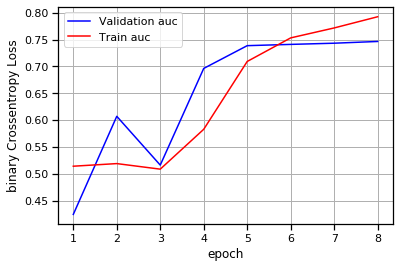

In [0]:
ig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,8+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history_1.history['val_auroc']
ty = history_1.history['auroc']
plt_dynamic_auc(x, vy, ty, ax)

#Tensorboard Screenshot


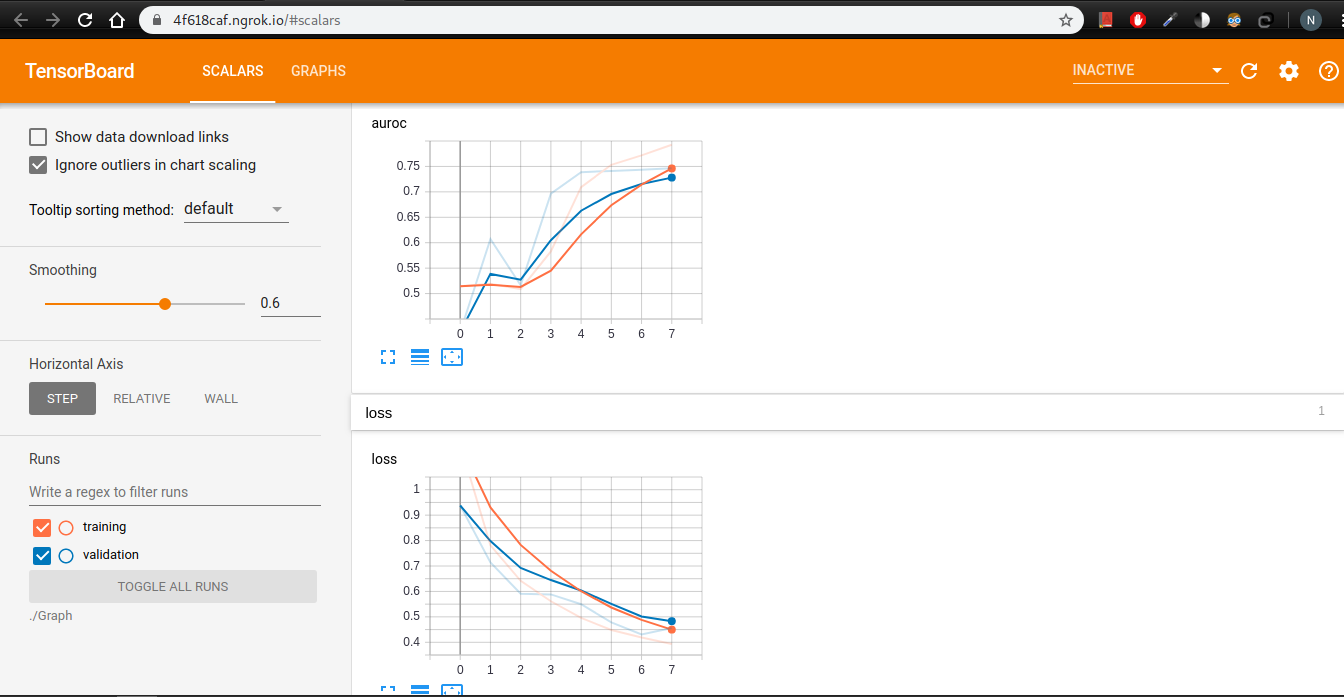

In [0]:
Image(retina=True, filename=working_dir+'tb_1.png')

### Model-2

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data feature 'essay' <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

#TF-idf vectorizer

In [0]:
vectorizer = TfidfVectorizer(min_df=10, max_features=10000)
x_train_essay_tfidf = vectorizer.fit_transform(X_train['essay'].values)
print("After vectorizations")
print(x_train_essay_tfidf.shape, Y_train.shape)

After vectorizations
(69918, 10000) (69918, 2)


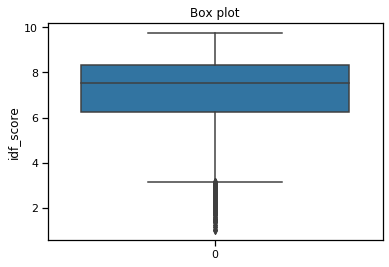

In [0]:
idf_score = vectorizer.idf_
sns.boxplot(data=idf_score)
plt.title('Box plot')
plt.ylabel('idf_score')
plt.show()

In [0]:
# getting all words
feature_names = np.asarray(vectorizer.get_feature_names()) 

index = []
for i in range(0,len(idf_score)):
    if idf_score[i] >= 4 and idf_score[i] <=10:
        index.append(i)
        
important_words = []
for i in index:
    important_words.append(feature_names[i])

print('Total words = ', len(feature_names))
print('Important words = ',len(important_words))

Total words =  10000
Important words =  9549


In [0]:
# train_data
x_train_essay_new = []
for sentence in tqdm_notebook(X_train['essay']):
    sen = []
    for word in sentence.split():
        if word in important_words:
            sen.append(word)      
    x_train_essay_new.append(' '.join(sen))

In [0]:
# cv_data
x_cv_essay_new = []
for sentence in tqdm_notebook(X_cv['essay']):
    sen = []
    for word in sentence.split():
        if word in important_words:
            sen.append(word)      
    x_cv_essay_new.append(' '.join(sen))

#test_data
x_test_essay_new = []
for sentence in tqdm_notebook(X_test['essay']):
    sen = []
    for word in sentence.split():
        if word in important_words:
            sen.append(word)    
    x_test_essay_new.append(' '.join(sen))

In [0]:
import pickle

with open(working_dir+'train-essay-imp.pkl', 'wb') as f:
  pickle.dump(x_train_essay_new, f)

with open(working_dir+'cv-essay-imp.pkl', 'wb') as f:
  pickle.dump(x_cv_essay_new, f)

with open(working_dir+'test-essay-imp.pkl', 'wb') as f:
  pickle.dump(x_test_essay_new, f)

In [0]:
print(len(x_train_essay_new))
print(len(x_cv_essay_new))
print(len(x_test_essay_new))

69918
17480
21850


In [0]:
text_essay = Tokenizer()
text_essay.fit_on_texts(x_train_essay_new)
vocab_size = len(text_essay.word_index) + 1
print('Total unique words in the x_train_essay_new',vocab_size)
encoded_train_new = text_essay.texts_to_sequences(x_train_essay_new)
encoded_cv_new = text_essay.texts_to_sequences(x_cv_essay_new)
encoded_test_new = text_essay.texts_to_sequences(x_test_essay_new)

Total unique words in the x_train_essay_new 9550


In [0]:
max_length = 300
padded_train_essay_new = pad_sequences(encoded_train_new, maxlen=max_length, padding='post')
padded_cv_essay_new = pad_sequences(encoded_cv_new, maxlen=max_length, padding='post')
padded_test_essay_new = pad_sequences(encoded_test_new, maxlen=max_length, padding='post')
print("length of padded_train_new data",len(padded_train_essay_new))
print("length of padded_cv_new data",len(padded_cv_essay_new))
print("length of padded_test_new data",len(padded_test_essay_new))

length of padded_train_new data 69918
length of padded_cv_new data 17480
length of padded_test_new data 21850


# Using Glove embedding for essays

In [0]:
def get_embedding_matrix(tokenizer,vocab_size):
  '''
  Takes input a tokenizer trained on the training set and vocabulary size
  
  Returns glove vector encoding for each word in the vocabulary (300 dim)
  as embedding_matrix.
  '''

  with open(root_path+'glove_vectors', 'rb') as f:
      model = pickle.load(f)
      glove_words =  set(model.keys())

  embedding_matrix = np.zeros((vocab_size, 300))
  cnt=0
  for word, i in tokenizer.word_index.items():
    if word in glove_words:
      embedding_matrix[i] = model[word]
  return embedding_matrix

In [0]:
embedding_matrix_train_2 = get_embedding_matrix(text_essay,vocab_size)
print(embedding_matrix_train_2.shape)

(9550, 300)


In [0]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

#First Input : Essays
essay_input = Input(shape=(300,), name='essay_input')
embedding = Embedding(input_dim=vocab_size,output_dim=300,weights=[embedding_matrix_train_2],input_length=300, trainable=False)(essay_input)
lstm_output = LSTM(units=150,dropout=0.5,return_sequences=True)(embedding)
flatten_1 = Flatten()(lstm_output)

#Second Input: school state

state_input = Input(shape=(1,),name='school_state')
state_embedding = Embedding(input_dim=school_state_vocab_size,output_dim=school_state_embd_size,input_length=1)(state_input)
flatten_2 = Flatten()(state_embedding)

#Third Input: project grade category
project_grade_cat_input = Input(shape=(1,),name='project_grade_category')
proj_gr_cat_embd = Embedding(input_dim=project_grade_cat_size,output_dim=project_grade_cat_embd_size,input_length=1)(project_grade_cat_input)
flatten_3 = Flatten()(proj_gr_cat_embd)

#Fourth Input: Project Category
project_cat_input = Input(shape=(1,), name='project_category')
proj_cat_embd = Embedding(input_dim=project_grade_cat_size,output_dim=project_grade_cat_embd_size,input_length=1)(project_cat_input)
flatten_4 = Flatten()(proj_cat_embd)

#Fifth Input: Teacher Prefix
teacher_pre_input = Input(shape=(1,),name='teacher_prefix')
teacher_pr_embd = Embedding(input_dim=teacher_prefix_vocab_size,output_dim=teacher_prefix_embd_size,input_length=1)(teacher_pre_input)
flatten_5 = Flatten()(teacher_pr_embd)

#Sixth Input: Project Subucategories
subcat_input = Input(shape=(1,),name='project_subcategory')
subcat_embd = Embedding(input_dim=subcategory_vocab_size,output_dim=subcategory_vocab_size,input_length=1)(subcat_input)
flatten_6 = Flatten()(subcat_embd)

#Remaining Input: Price, Number of previously posted project
remaining_input = Input(shape=(2,),name='remaining_input')
dense_1 = Dense(1, activation='relu',kernel_initializer="he_normal",kernel_regularizer=l2(0.001))(remaining_input)

#concatenating all inputs together
cacatenated_inputs = concatenate([flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,flatten_6,dense_1])
# x = Dense(256,kernel_initializer="glorot_normal",kernel_regularizer=l2(0.001))(x)
# x = LeakyReLU(alpha=0.3)(x)
# x = Dropout(0.6)(x)
# # x = BatchNormalization()(x)

# x = Dense(128,kernel_initializer="glorot_normal",kernel_regularizer=l2(0.001))(x)
# x = LeakyReLU(alpha=0.3)(x)
# x = Dropout(0.5)(x)
# # x = BatchNormalization()(x)
# x = Dense(64,kernel_initializer="glorot_normal",kernel_regularizer=l2(0.001))(x)
# x = LeakyReLU(alpha=0.3)(x)
# x = Dropout(0.5)(x)
# x = Dense(32,kernel_initializer="glorot_normal",kernel_regularizer=l2(0.001))(x)
# x = LeakyReLU(alpha=0.3)(x)
# x = Dropout(0.5)(x)
# x = Dense(16, kernel_initializer="glorot_normal",kernel_regularizer=l2(0.001))(x)
# x = LeakyReLU(alpha=0.3)(x)



x = Dense(256, activation='relu',kernel_initializer="he_normal",kernel_regularizer=l2(0.001))(cacatenated_inputs)
x = Dropout(.5)(x)
x = Dense(128, activation='relu',kernel_initializer="he_normal",kernel_regularizer=l2(0.001))(x)
x = Dropout(.5)(x)
x = BatchNormalization()(x)

x = Dense(64, activation='relu',kernel_initializer="he_normal",kernel_regularizer=l2(0.001))(x)


final_output = Dense(2, activation='softmax')(x)

model_2 = Model(inputs=[essay_input, state_input, project_grade_cat_input, project_cat_input, teacher_pre_input, subcat_input, remaining_input], outputs=final_output)
print(model_2.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
essay_input (InputLayer)        (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 300, 300)     2865000     essay_input[0][0]                
__________________________________________________________________________________________________
school_state (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
project_grade_category (InputLa (None, 1)            0                                            
____________________________________________________________________________________________

In [0]:
# checkpoint
file_path=working_dir+"weights-improvement-{epoch:02d}-{val_auroc:.2f}.hdf5"
checkpoint_2 = ModelCheckpoint(filepath=file_path,
                             monitor="val_auroc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

# earlystop_2 = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# reduce_lr_2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.002,verbose = 1)
# earlystop_2 = EarlyStopping(monitor = 'val_auroc', 
#                             mode="max",
#                             min_delta = 0, 
#                             patience = 3,
#                             verbose = 1,)
# reduce_lr_2 = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, verbose = 1, min_delta = 0.0001)

tbc_2=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://6f9e244c.ngrok.io


In [0]:
callbacks_list = [checkpoint_2, TensorBoardColabCallback(tbc_2)]

train_2 = [padded_train_essay_new,
           school_state_encoded_train,
           project_grade_cat_encoded_train,
           category_encoded_train,
           teacher_prefix_encoded_train,
           subcategory_encoded_train,
           remaining_train]


cv_2 = [padded_cv_essay_new,
           school_state_encoded_cv,
           project_grade_cat_encoded_cv,
           category_encoded_cv,
           teacher_prefix_encoded_cv,
           subcategory_encoded_cv,
           remaining_cv]

test_2 = [padded_test_essay_new,
           school_state_encoded_test,
           project_grade_cat_encoded_test,
           category_encoded_test,
           teacher_prefix_encoded_test,
           subcategory_encoded_test,
           remaining_test]

In [0]:
# model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auroc])
model_2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=[auroc])
history_2 = model_2.fit(train_2,Y_train,validation_data=(cv_2,Y_cv),epochs=50,batch_size=512,verbose=1,callbacks=callbacks_list)

Train on 69918 samples, validate on 17480 samples
Epoch 1/50
69918/69918 [==============================] - 118s 2ms/step - loss: 0.9592 - auroc: 0.5416 - val_loss: 0.7789 - val_auroc: 0.5906

Epoch 00001: val_auroc improved from -inf to 0.59057, saving model to /content/gdrive/My Drive/model-weights-lstm/weights-improvement-01-0.59.hdf5

Epoch 2/50
69918/69918 [==============================] - 120s 2ms/step - loss: 0.7046 - auroc: 0.6163 - val_loss: 0.6525 - val_auroc: 0.6492

Epoch 00002: val_auroc improved from 0.59057 to 0.64923, saving model to /content/gdrive/My Drive/model-weights-lstm/weights-improvement-02-0.65.hdf5
Epoch 3/50
69918/69918 [==============================] - 117s 2ms/step - loss: 0.6136 - auroc: 0.6500 - val_loss: 0.5941 - val_auroc: 0.6834

Epoch 00003: val_auroc improved from 0.64923 to 0.68342, saving model to /content/gdrive/My Drive/model-weights-lstm/weights-improvement-03-0.68.hdf5
Epoch 4/50
69918/69918 [==============================] - 118s 2ms/step -

In [0]:
#https://stackoverflow.com/posts/54978213/revisions
custom_objects = {"auroc":auroc}
from keras.models import load_model
best_model_2 = load_model('/content/gdrive/My Drive/model-weights-lstm/weights-improvement-28-0.72.hdf5',custom_objects=custom_objects)

In [0]:
result = best_model_2.evaluate(x=test_2, y=Y_test, batch_size=512)
print("{} of test data {}". format(best_model_2.metrics_names[0],result[0]))
print("{} of test data {}". format(best_model_2.metrics_names[1],result[1]))

21850/21850 [==============================] - 15s 673us/step
loss of test data 0.405921457484876
auroc of test data 0.7163328799352613


In [0]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test,best_model_2.predict(test_2,batch_size=512))

0.7158541673812986

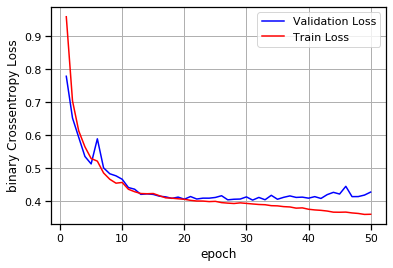

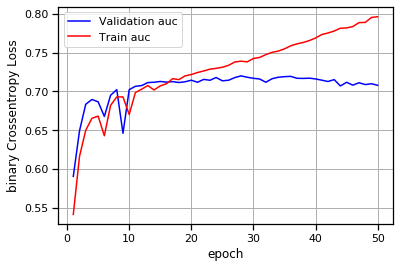

In [0]:
best_model_2.save(working_dir+"best_model_2.h5")

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,50+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history_2.history['val_loss']
ty = history_2.history['loss']
plt_dynamic(x, vy, ty, ax)


def plt_dynamic_auc(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation auc")
    ax.plot(x, ty, 'r', label="Train auc")
    plt.legend()
    plt.grid()
    fig.canvas.draw()


ig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,50+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history_2.history['val_auroc']
ty = history_2.history['auroc']
plt_dynamic_auc(x, vy, ty, ax)

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

#Encoding Categorical Features

#### One hot encoding: clean_categories


In [0]:
my_counter = Counter()
for word in X_train['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [123]:
# we use count vectorizer to convert the values into one 
vectorizer_category = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_category.fit(X_train['clean_categories'].values)

X_train_category_ohe = vectorizer_category.transform(X_train['clean_categories'].values)
X_cv_category_ohe = vectorizer_category.transform(X_cv['clean_categories'].values)
X_test_category_ohe = vectorizer_category.transform(X_test['clean_categories'].values)

print(vectorizer_category.get_feature_names())
print("Shape of X_train after one hot encodig ",X_train_category_ohe.shape)
print("Shape of X_cv after one hot encodig ",X_cv_category_ohe.shape)
print("Shape of X_test after one hot encodig ",X_test_category_ohe.shape)
print("Print some random encoded categories: ")
print(X_train_category_ohe[0].toarray())
print(X_cv_category_ohe[0].toarray())
print(X_test_category_ohe[15].toarray())

['warmth', 'care_hunger', 'history_civics', 'music_arts', 'appliedlearning', 'specialneeds', 'health_sports', 'math_science', 'literacy_language']
Shape of X_train after one hot encodig  (69918, 9)
Shape of X_cv after one hot encodig  (17480, 9)
Shape of X_test after one hot encodig  (21850, 9)
Print some random encoded categories: 
[[0 0 0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 1 0 0]]


#### One hot encoding: clean_subcategories


In [124]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in X_train['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

# we use count vectorizer to convert the values into one 
vectorizer_subcategory = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_subcategory.fit(X_train['clean_subcategories'].values)

X_train_subcategory_ohe = vectorizer_subcategory.transform(X_train['clean_subcategories'].values)
X_cv_subcategory_ohe = vectorizer_subcategory.transform(X_cv['clean_subcategories'].values)
X_test_subcategory_ohe = vectorizer_subcategory.transform(X_test['clean_subcategories'].values)

print(vectorizer_subcategory.get_feature_names())
print("Shape of X_train subcategory after one hot encoding ",X_train_subcategory_ohe.shape)
print("Shape of X_cv subcategory after one hot encoding ",X_cv_subcategory_ohe.shape)
print("Shape of X_test subcategory after one hot encoding ",X_test_subcategory_ohe.shape)
print("Print some random encoded categories: ")

print(X_train_subcategory_ohe[0].toarray())
print(X_cv_subcategory_ohe[0].toarray())
print(X_test_subcategory_ohe[10].toarray())

['economics', 'communityservice', 'financialliteracy', 'parentinvolvement', 'civics_government', 'extracurricular', 'foreignlanguages', 'nutritioneducation', 'warmth', 'care_hunger', 'performingarts', 'socialsciences', 'charactereducation', 'teamsports', 'other', 'college_careerprep', 'music', 'history_geography', 'health_lifescience', 'earlydevelopment', 'esl', 'gym_fitness', 'environmentalscience', 'visualarts', 'health_wellness', 'appliedsciences', 'specialneeds', 'literature_writing', 'mathematics', 'literacy']
Shape of X_train subcategory after one hot encoding  (69918, 30)
Shape of X_cv subcategory after one hot encoding  (17480, 30)
Shape of X_test subcategory after one hot encoding  (21850, 30)
Print some random encoded categories: 
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0]]


####  One hot encoding: school_state


In [125]:
# create a vocabulary for states
unique_states = np.unique(X_train['school_state'].values)

vectorizer_state = CountVectorizer(vocabulary=unique_states,lowercase=False,binary=True)
vectorizer_state.fit(X_train['school_state'].values)

X_train_school_state_ohe = vectorizer_state.transform(X_train['school_state'].values)
X_cv_school_state_ohe = vectorizer_state.transform(X_cv['school_state'].values)
X_test_school_state_ohe = vectorizer_state.transform(X_test['school_state'].values)

print(vectorizer_state.get_feature_names())
print("Shape of X_train school_state after one hot encodig ",X_train_school_state_ohe.shape)
print("Shape of X_cv school_state after one hot encodig ",X_cv_school_state_ohe.shape)
print("Shape of X_test school_state after one hot encodig ",X_test_school_state_ohe.shape)
print("Print some random encoded school_state: ")
print(X_train_school_state_ohe[0].toarray())
print(X_cv_school_state_ohe[0].toarray())
print(X_test_school_state_ohe[15].toarray())

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
Shape of X_train school_state after one hot encodig  (69918, 51)
Shape of X_cv school_state after one hot encodig  (17480, 51)
Shape of X_test school_state after one hot encodig  (21850, 51)
Print some random encoded school_state: 
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


#### One hot encoding: teacher_prefix


In [126]:
unique_teacher_prefix = np.unique(X_train['teacher_prefix'])

vectorizer_teacher_prefix = CountVectorizer(vocabulary=unique_teacher_prefix,lowercase=False,binary=True)
vectorizer_teacher_prefix.fit(X_train['teacher_prefix'].values)

X_train_teacher_prefix_ohe = vectorizer_teacher_prefix.transform(X_train['teacher_prefix'].values)
X_cv_teacher_prefix_ohe = vectorizer_teacher_prefix.transform(X_cv['teacher_prefix'].values)
X_test_teacher_prefix_ohe = vectorizer_teacher_prefix.transform(X_test['teacher_prefix'].values)

print(vectorizer_teacher_prefix.get_feature_names())
print("Shape of X_train clean_teacher_prefix after one hot encodig ",X_train_teacher_prefix_ohe.shape)
print("Shape of X_cv clean_teacher_prefix after one hot encodig ",X_cv_teacher_prefix_ohe.shape)
print("Shape of X_test clean_teacher_prefix after one hot encodig ",X_test_teacher_prefix_ohe.shape)
print("Print some random encoded clean_teacher_prefix: ")
print(X_train_teacher_prefix_ohe[0].toarray())
print(X_cv_teacher_prefix_ohe[0].toarray())
print(X_test_teacher_prefix_ohe[15].toarray())

['dr', 'mr', 'mrs', 'ms', 'teacher']
Shape of X_train clean_teacher_prefix after one hot encodig  (69918, 5)
Shape of X_cv clean_teacher_prefix after one hot encodig  (17480, 5)
Shape of X_test clean_teacher_prefix after one hot encodig  (21850, 5)
Print some random encoded clean_teacher_prefix: 
[[0 0 1 0 0]]
[[0 1 0 0 0]]
[[0 0 0 1 0]]


#### One hot encoding: project_grade_category


In [127]:
unique_grades = np.unique(X_train['project_grade_category'])

vectorizer_grade = CountVectorizer(vocabulary=unique_grades,lowercase=False,binary=True)
vectorizer_grade.fit(X_train['project_grade_category'].values)


X_train_grade_category_ohe = vectorizer_grade.transform(X_train['project_grade_category'].values)
X_cv_grade_category_ohe = vectorizer_grade.transform(X_cv['project_grade_category'].values)
X_test_grade_category_ohe = vectorizer_grade.transform(X_test['project_grade_category'].values)

print(vectorizer_grade.get_feature_names())
print("Shape of X_train clean_grade_category after one hot encodig ",X_train_grade_category_ohe.shape)
print("Shape of X_cv clean_grade_category after one hot encodig ",X_cv_grade_category_ohe.shape)
print("Shape of X_test clean_grade_category after one hot encodig ",X_test_grade_category_ohe.shape)
print("Print some random encoded clean_grade_category: ")
print(X_train_grade_category_ohe[0].toarray())
print(X_cv_grade_category_ohe[0].toarray())
print(X_test_grade_category_ohe[15].toarray())

['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
Shape of X_train clean_grade_category after one hot encodig  (69918, 4)
Shape of X_cv clean_grade_category after one hot encodig  (17480, 4)
Shape of X_test clean_grade_category after one hot encodig  (21850, 4)
Print some random encoded clean_grade_category: 
[[1 0 0 0]]
[[1 0 0 0]]
[[0 1 0 0]]


In [128]:
print(X_train_category_ohe.shape)
print(X_train_subcategory_ohe.shape)
print(X_train_school_state_ohe.shape)
print(X_train_grade_category_ohe.shape)
print(X_train_teacher_prefix_ohe.shape)
print(X_train_normal_previous_project.shape)
print(X_train_price_normalized.shape)

(69918, 9)
(69918, 30)
(69918, 51)
(69918, 4)
(69918, 5)
(69918, 1)
(69918, 1)


In [0]:
f1 = X_train_school_state_ohe
f2 = X_train_category_ohe
f3 = X_train_subcategory_ohe
f4 = X_train_grade_category_ohe
f5 = X_train_teacher_prefix_ohe
f6 = np.array(X_train_price_normalized)
f7 = np.array(X_train_normal_previous_project)
remaining_xtrain = hstack((f1,f2,f3,f4,f5,f6,f7))

In [0]:
remaining_xtrain = np.array(remaining_xtrain.todense())
remaining_xtrain = np.expand_dims(remaining_xtrain,2)#remaining_xtrain.reshape(remaining_xtrain.shape[0],remaining_xtrain.shape[1],1)

In [131]:
remaining_xtrain.shape

(69918, 101, 1)

In [132]:
f1 = X_cv_school_state_ohe
f2 = X_cv_category_ohe
f3 = X_cv_subcategory_ohe
f4 = X_cv_grade_category_ohe
f5 = X_cv_teacher_prefix_ohe
f6 = np.array(X_cv_price_normalized)
f7 = np.array(X_cv_normal_previous_project)
remaining_xcv = hstack((f1,f2,f3,f4,f5,f6,f7))
print(remaining_xcv.shape)

(17480, 101)


In [133]:
remaining_xcv  = np.array(remaining_xcv.todense())
remaining_xcv = np.expand_dims(remaining_xcv,2)
remaining_xcv.shape

(17480, 101, 1)

In [134]:
f1 = X_test_school_state_ohe
f2 = X_test_category_ohe
f3 = X_test_subcategory_ohe
f4 = X_test_grade_category_ohe
f5 = X_test_teacher_prefix_ohe
f6 = np.array(X_test_price_normalized)
f7 = np.array(X_test_normal_previous_project)
remaining_xtest = hstack((f1,f2,f3,f4,f5,f6,f7))
print(remaining_xtest.shape)

(21850, 101)


In [135]:
remaining_xtest  = np.array(remaining_xtest.todense())
remaining_xtest = np.expand_dims(remaining_xtest,2)
remaining_xtest.shape

(21850, 101, 1)

In [137]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

#First Input : Essays
essay_input = Input(shape=(300,), name='essay_input')
embedding = Embedding(input_dim=vocab_size,output_dim=300,weights=[embedding_matrix_train],input_length=300, trainable=False)(essay_input)
lstm_output = LSTM(units=150,dropout=0.5,return_sequences=True)(embedding)
flatten_1 = Flatten()(lstm_output)

#Remaining Input
remaining_input = Input(shape=(101,1),name='remaining_input')

x = Conv1D(filters=128, kernel_size = 3, padding='valid', activation='relu', kernel_initializer='he_normal',)(remaining_input)
x = Conv1D(filters=128, kernel_size = 3, padding='valid', activation='relu', kernel_initializer='he_normal',)(x)
x = Flatten()(x)

#concatenating all inputs together
cacatenated_inputs = concatenate([flatten_1, x])

x = Dense(256, activation='relu',kernel_initializer="he_normal",kernel_regularizer=l2(0.001))(cacatenated_inputs)
x = Dropout(.5)(x)
x = Dense(128, activation='relu',kernel_initializer="he_normal",kernel_regularizer=l2(0.001))(x)
x = Dropout(.5)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu',kernel_initializer="he_normal",kernel_regularizer=l2(0.001))(x)
final_output = Dense(2, activation='softmax')(x)

model_3 = Model(inputs=[essay_input, remaining_input], outputs=[final_output])
print(model_3.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
essay_input (InputLayer)        (None, 300)          0                                            
__________________________________________________________________________________________________
remaining_input (InputLayer)    (None, 101, 1)       0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 300, 300)     14200800    essay_input[0][0]                
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 99, 128)      512         remaining_input[0][0]            
____________________________________________________________________________________________

In [138]:
# checkpoint
file_path=working_dir+"weights-improvement-{epoch:02d}-{val_auroc:.2f}.hdf5"
checkpoint_3 = ModelCheckpoint(filepath=file_path,
                             monitor="val_auroc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)
tbc_3 = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://970ea298.ngrok.io


In [0]:
callbacks_list = [checkpoint_3, TensorBoardColabCallback(tbc_3)]

train_3 = [padded_train_essay, remaining_xtrain]

cv_3 = [padded_cv_essay,remaining_xcv]
      
test_3 = [padded_test_essay,remaining_xtest]

In [140]:
model_3.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=[auroc])
history_3 = model_3.fit(train_3,Y_train,validation_data=(cv_3,Y_cv),epochs=50,batch_size=512,verbose=1,callbacks=callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 69918 samples, validate on 17480 samples


Epoch 1/50
69918/69918 [==============================] - 74s 1ms/step - loss: 1.1136 - auroc: 0.5101 - val_loss: 0.8220 - val_auroc: 0.5471

Epoch 00001: val_auroc improved from -inf to 0.54714, saving model to /content/gdrive/My Drive/model-weights-lstm/weights-improvement-01-0.55.hdf5

Epoch 2/50
69918/69918 [==============================] - 68s 969us/step - loss: 0.7480 - auroc: 0.5209 - val_loss: 0.6682 - val_auroc: 0.6204

Epoch 00002: val_auroc improved from 0.54714 to 0.62042, saving model to /content/gdrive/My Drive/model-weights-lstm/weights-improvement-02-0.62.hdf5
Epoch 3/50
69918/69918 [==============================] - 68s 970us/step - loss: 0.6413 - auroc: 0.5808 - val_loss: 0.5908 - val_auroc: 0.6955

Epoch 00003: val_auroc improved from 0.62042 to 0.69546, saving model to /content/gdrive/My Drive/model-weights-lstm/weights

In [0]:
#https://stackoverflow.com/posts/54978213/revisions
custom_objects = {"auroc":auroc}
from keras.models import load_model
best_model_3 = load_model('/content/gdrive/My Drive/model-weights-lstm/weights-improvement-30-0.77.hdf5',custom_objects=custom_objects)

In [142]:
result = best_model_3.evaluate(x=test_3, y=Y_test, batch_size=512)
print("{} of test data {}". format(best_model_3.metrics_names[0],result[0]))
print("{} of test data {}". format(best_model_3.metrics_names[1],result[1]))

21850/21850 [==============================] - 9s 392us/step
loss of test data 0.3775796339277272
auroc of test data 0.7668925418496343


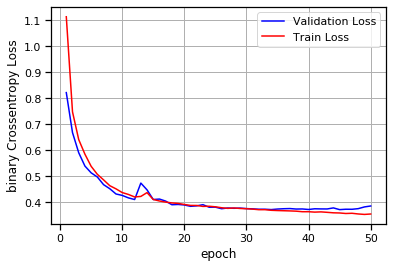

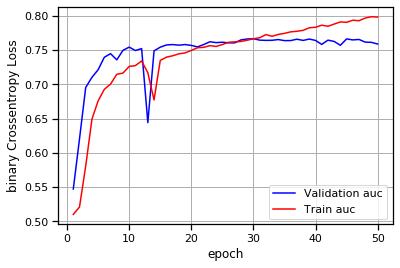

In [143]:
best_model_3.save(working_dir+"best_model_3.h5")

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,50+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history_3.history['val_loss']
ty = history_3.history['loss']
plt_dynamic(x, vy, ty, ax)


def plt_dynamic_auc(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation auc")
    ax.plot(x, ty, 'r', label="Train auc")
    plt.legend()
    plt.grid()
    fig.canvas.draw()


ig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,50+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history_3.history['val_auroc']
ty = history_3.history['auroc']
plt_dynamic_auc(x, vy, ty, ax)

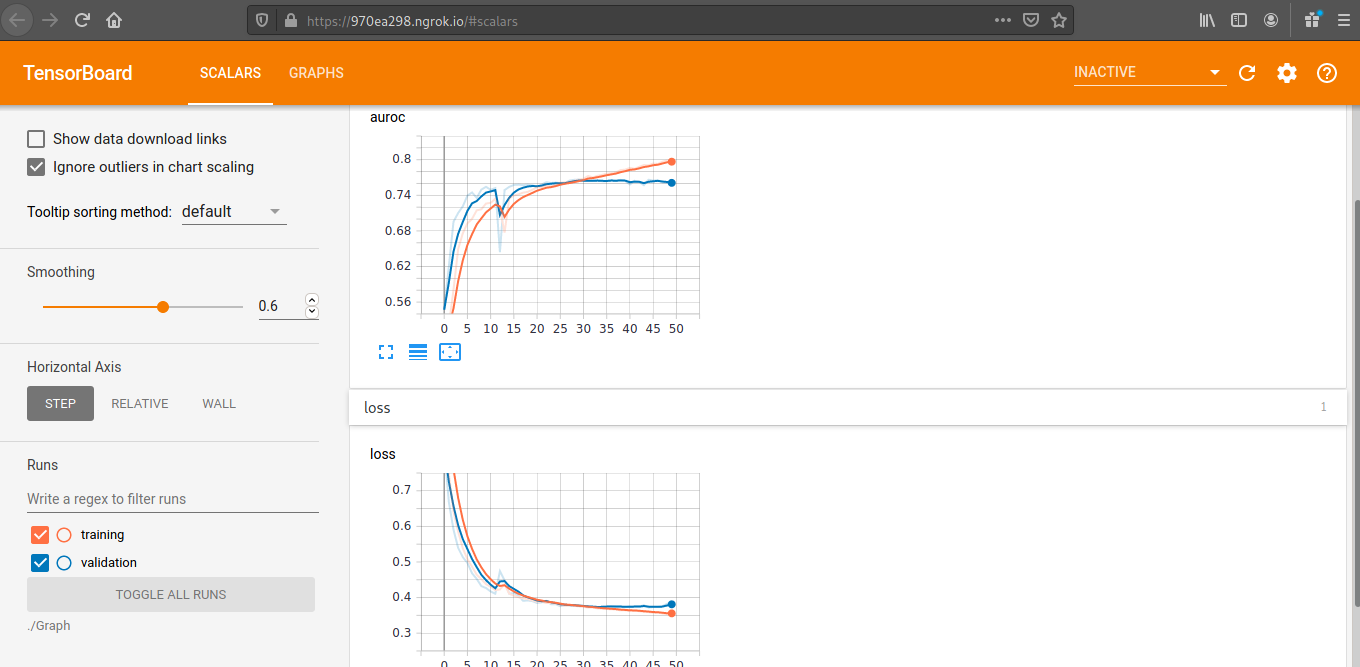

In [145]:
Image(retina=True, filename=working_dir+'tb3.png')

# Conclusion

In [147]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "train_auc", "val_auc", "test_auc","val_loss","test_loss"]

x.add_row(["Model_1", 0.7926,0.7465,0.7424,0.4562,0.4563])
x.add_row(["Model_2", 0.7962, 0.7079,0.7163,0.4282,0.4034])
x.add_row(["Model_3", 0.7666,0.7558,0.7668,0.3680,0.37757])

print(x)

+---------+-----------+---------+----------+----------+-----------+
|  Model  | train_auc | val_auc | test_auc | val_loss | test_loss |
+---------+-----------+---------+----------+----------+-----------+
| Model_1 |   0.7926  |  0.7465 |  0.7424  |  0.4562  |   0.4563  |
| Model_2 |   0.7962  |  0.7079 |  0.7163  |  0.4282  |   0.4034  |
| Model_3 |   0.7666  |  0.7558 |  0.7668  |  0.368   |  0.37757  |
+---------+-----------+---------+----------+----------+-----------+
